# Numerical Representation of images
In this notebook we study how images are represented as arrays of numbers in the computer.

## Importing modules

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import requests
import os
import shutil
from tqdm import tqdm
import zipfile

## Fetching the Tiny ImageNet data set

In this notebook we shall use the [Tiny ImageNet data set](https://tiny-imagenet.herokuapp.com/) to illustrate how images are stored and processed in computers. As explained in the linked web page, this data set is smaller version of the [ImageNet](http://www.image-net.org/) data set with 500 training, 50 validation and 50 test images of 200 represented classes. In this notebook we use this data set to the basic elements of image representation by computers. 

#### Generating tree structure

In [10]:
def generate_tree(generate_dirs,overwrite=False):
    if overwrite:
        pbar = tqdm(generate_dirs)
        for d in pbar:
            if os.path.isdir(d):
                pbar.set_description(f"Removing directory {d}")
                shutil.rmtree(d)
            else: 
                pbar.set_description(f"Directory {d} does not exist. Skipping.")
    pbar = tqdm(generate_dirs)    
    for d in pbar:
        if not os.path.isdir(d):
            pbar.set_description(f"Generating directory {d}")
            os.mkdir(d)
        else:
            pbar.set_description(f"Directory {d} already exists. Skipping")

In [15]:
parent_dir = "/home/rio/data_sets"
tiny_imagenet_dir = os.path.join(parent_dir, "tiny_imagenet")
generate_dirs = [parent_dir,tiny_imagenet_dir]
overwrite=False
generate_tree(generate_dirs,overwrite)

Directory /home/rio/data_sets/tiny_imagenet already exists. Skipping: 100%|██████████| 2/2 [00:00<00:00, 1577.10it/s]


#### Downloading and extracting data


In [16]:
def fetch_data(url, save_path, unzip_path,chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as fd:
        pbar = tqdm(r.iter_content(chunk_size=chunk_size),desc=f"Downloading data to {save_path}")
        for chunk in pbar:
            fd.write(chunk)
    with zipfile.ZipFile(save_path, 'r') as zip_file:
        pbar = tqdm(zip_file.namelist(),total=len(zip_file.namelist()),desc = f"Extracting to {unzip_path}")
        for file in pbar:
            zip_file.extract(member=file, path=unzip_path)

        # Extract each file to another directory
        # If you want to extract to current working directory, don't specify path
        #zip_file.extract(member=file, path=directory)
        #print(f"Extracting to {unzip_path}")
        #zip_ref.extractall(unzip_path)
    
            

In [17]:
%%time
tiny_imagenet_url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
save_path = os.path.join(tiny_imagenet_dir, "tiny-imagenet-200.zip")
unzip_path = tiny_imagenet_dir
fetch_data(tiny_imagenet_url, save_path, unzip_path,chunk_size=128)

Extracting to /home/rio/data_sets/tiny_imagenet: 100%|██████████| 120609/120609 [00:09<00:00, 12356.91it/s]

CPU times: user 38.9 s, sys: 5.23 s, total: 44.1 s
Wall time: 1min 23s


## Loading and displaying images

Let us first understand how our data set is organized. We can list our directory `tiny_imagenet_dir` to find where the images have been unzipped.

In [18]:
os.listdir(unzip_path)

['tiny-imagenet-200', 'tiny-imagenet-200.zip']

In [19]:
images_dir = os.path.join(unzip_path,os.listdir(unzip_path)[0])
os.listdir(images_dir)

['words.txt', 'val', 'wnids.txt', 'test', 'train']

So we have now found where our training set went to. Let us look what is inside.

In [25]:
train_dir = os.path.join(images_dir,"train")
val_dir = os.path.join(images_dir,"train")
test_dir = os.path.join(images_dir,"train")
train_dir_contents = sorted(os.listdir(train_dir))
print("train_dir: ", train_dir_contents)
print("\n")
print("Length of train_dir: ", len(train_dir_contents))

train_dir:  ['n01443537', 'n01629819', 'n01641577', 'n01644900', 'n01698640', 'n01742172', 'n01768244', 'n01770393', 'n01774384', 'n01774750', 'n01784675', 'n01855672', 'n01882714', 'n01910747', 'n01917289', 'n01944390', 'n01945685', 'n01950731', 'n01983481', 'n01984695', 'n02002724', 'n02056570', 'n02058221', 'n02074367', 'n02085620', 'n02094433', 'n02099601', 'n02099712', 'n02106662', 'n02113799', 'n02123045', 'n02123394', 'n02124075', 'n02125311', 'n02129165', 'n02132136', 'n02165456', 'n02190166', 'n02206856', 'n02226429', 'n02231487', 'n02233338', 'n02236044', 'n02268443', 'n02279972', 'n02281406', 'n02321529', 'n02364673', 'n02395406', 'n02403003', 'n02410509', 'n02415577', 'n02423022', 'n02437312', 'n02480495', 'n02481823', 'n02486410', 'n02504458', 'n02509815', 'n02666196', 'n02669723', 'n02699494', 'n02730930', 'n02769748', 'n02788148', 'n02791270', 'n02793495', 'n02795169', 'n02802426', 'n02808440', 'n02814533', 'n02814860', 'n02815834', 'n02823428', 'n02837789', 'n02841315',

Each of the sudirectories listed above correspond to a class. Let us choose the first subdirectory and have a general view of what is inside.

In [31]:
first_train_dir = os.path.join(train_dir,train_dir_contents[0])
print(f"Contents of {first_train_dir}: ")
print( os.listdir(first_train_dir))

Contents of /home/rio/data_sets/tiny_imagenet/tiny-imagenet-200/train/n01443537: 
['images', 'n01443537_boxes.txt']


So we can select a random sample from the `images` directory listed above.

In [42]:
%%time
nrows = 4
ncols= 4
sample_size = nrows*ncols
sample_dir = os.path.join(first_train_dir,"images")
sample_dir_contents = os.listdir(sample_dir)
sampled_image_files = list(np.random.permutation(sample_dir_contents)[:sample_size])
random_images = [mpimg.imread(os.path.join(sample_dir,f)) for f in sampled_image_files]


CPU times: user 4.44 ms, sys: 49 µs, total: 4.49 ms
Wall time: 4.07 ms


Let us visualize what is inside the list `random_images`

In [44]:
def plot_images(images,nrows,ncols,figsize=None,return_fig=False):
    if nrows is None or ncols is None:
        nrows, ncols = 1, len(image_filenames)
    n_plots = nrows*ncols
    fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize)
    for ix, img in enumerate(images):
        i = ix//ncols
        j = ix%nrows
        ax[i,j].imshow(img)#,cmap = "Greys_r")
    if return_fig:
        return fig,ax

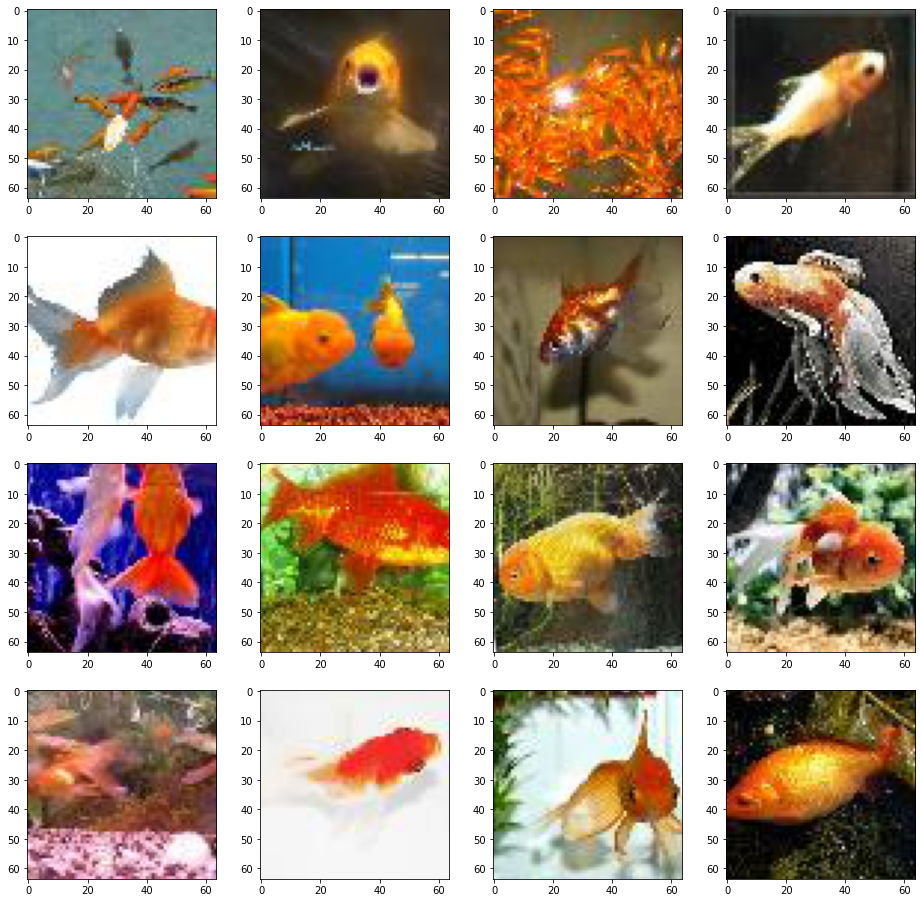

In [45]:
figsize = (16,16)
return_fig = False
plot_images(random_images,nrows,ncols,figsize,return_fig)

Golden fishes! This agrees with the fact that each subdirectory corresponds to a particular class. Let us now visualize arandom sample of the full data set.  

In [28]:

random_image_files = list(np.random.permutation(os.listdir(first_train_dir))[:sample_size])
random_images = [mpimg.imread(os.path.join(first_train_dir,f))for f in random_image_files]
figsize=(16,16)
return_fig=False
plot_images(random_images,nrows,ncols,figsize,return_fig)

UnidentifiedImageError: cannot identify image file '/home/rio/data_sets/tiny_imagenet/tiny-imagenet-200/train/n01443537/n01443537_boxes.txt'